In [1]:
import pandas as pd
import os
from os.path import isfile, join
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
covid_folder = '../csse_covid_19_data/csse_covid_19_daily_reports/'
covid_files = [os.path.join(covid_folder,f) for f in os.listdir(covid_folder) if isfile(join(covid_folder, f)) and f.endswith('.csv')]

In [3]:
def aggregate_data(covid_files):
    all_data =[]
    for file in covid_files:
        df= pd.read_csv(file)
        df.head()
        head, tail = os.path.split(file)
        date=datetime.datetime.strptime(tail[0:-4], '%m-%d-%Y')
        df['Date']=date
        df=df.rename(columns={'Country/Region':'Country'})
        col_to_remove=set(df.columns).intersection(['Last Update', 'Latitude', 'Longitude'])
        df=df.drop(columns=col_to_remove)
        all_data.append(df)
    
    all_df = pd.concat(all_data, sort=False).sort_values(by='Date', ascending=True)
    country_aggregated=all_df.groupby(by=['Date', 'Country']).agg('sum')
    country_aggregated.sort_values(by=['Date', 'Deaths'] , ascending=[False, False], inplace=True)
    country_aggregated.reset_index(inplace=True)
    return country_aggregated

In [4]:
def get_country_timeseries(df, countries, country_label):
    df = df.copy()
    result = df[(df['Country'].isin(list(countries))) ]
    result['Country']= country_label
    result=result.groupby(by=['Date', 'Country']).sum()
    result.reset_index(inplace=True)
    result.sort_values(by=['Date'], ascending= True , inplace=True)
    result['Death_per_day']= result['Deaths'].diff()
    start= result[((result['Death_per_day'] == 0) | (result['Death_per_day'].isna())) == False]['Date'].min()
    result=result[result['Date']>= start]
    result['Date_reset'] = (result['Date']-start).dt.days
    max_death= result['Deaths'].max()
    result['Death_per_day']=result['Death_per_day'].rolling(3, center=True).mean()
    result['Death_per_day']= result['Death_per_day']
    result.reset_index(inplace=True)
    return result,start

In [5]:
def plot_dist(data, label):
    plt.figure()
    ax=plt.gcf()
    plt.bar(data['Date_reset'],data['Death_per_day'], label=label)
    ax.legend()

In [6]:
country_aggregated = aggregate_data(covid_files)

country_aggregated.head()

,Date,Country,Confirmed,Deaths,Recovered
0,2020-03-17,China,81058.0,3230.0,68798.0
1,2020-03-17,Italy,31506.0,2503.0,2941.0
2,2020-03-17,Iran,16169.0,988.0,5389.0
3,2020-03-17,Spain,11748.0,533.0,1028.0
4,2020-03-17,France,7683.0,148.0,12.0


<BarContainer object of 56 artists>

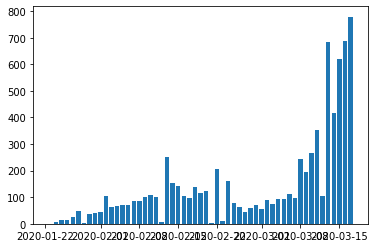

In [7]:
aggregated=country_aggregated.groupby(by='Date').sum()
aggregated.sort_values(by=['Date'], ascending= True , inplace=True)
aggregated['Confirmed']=aggregated['Confirmed'].diff()
aggregated['Deaths']=aggregated['Deaths'].diff()
aggregated['Confirmed'] = aggregated['Confirmed']#.rolling(3,center=True).mean()
aggregated.reset_index(inplace=True)
plt.figure()
plt.bar(aggregated['Date'], aggregated['Deaths'])

In [8]:
us, us_start = get_country_timeseries(country_aggregated, ['US'], 'US')
italy, italy_start = get_country_timeseries(country_aggregated, ['Italy'], 'Italy')
china, china_start = get_country_timeseries(country_aggregated, ['Mainland China' , 'China'], 'China')
iran, iran_start = get_country_timeseries(country_aggregated, ['Iran'], "Iran")

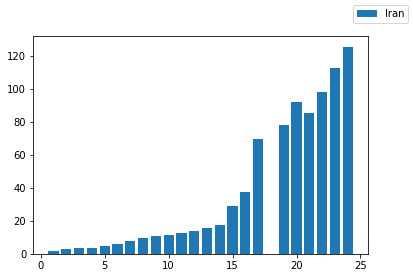

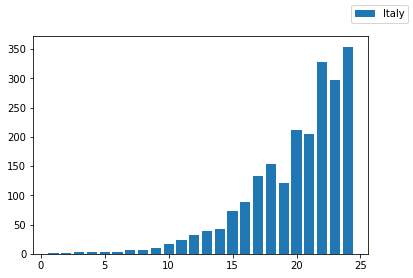

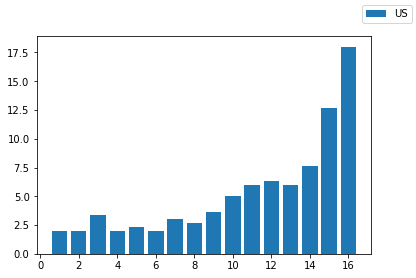

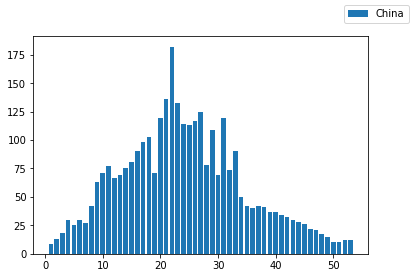

In [9]:
plot_dist(iran, "Iran")
plot_dist(italy, "Italy")
plot_dist(us, "US")
plot_dist(china, "China")

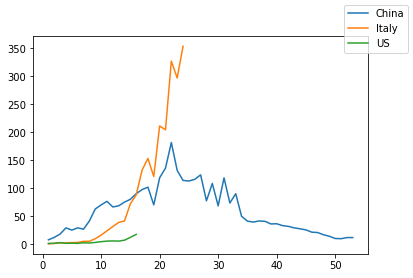

In [10]:
plt.figure()
ax=plt.gcf()
data, label=china, "China"
plt.plot(data['Date_reset'],data['Death_per_day'], label=label)
data, label=italy, "Italy"
plt.plot(data['Date_reset'],data['Death_per_day'], label=label)
data, label=us, "US"
plt.plot(data['Date_reset'],data['Death_per_day'], label=label)
ax.legend()